In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime
import requests

In [150]:
%config InlineBackend.figure_format = 'retina'

In [151]:
# wget https://sfc-project-files.s3.amazonaws.com/project-feeds/covid19_us_cases_ca.json
data = requests.get('https://sfc-project-files.s3.amazonaws.com/project-feeds/covid19_us_cases_ca.json').json()
df = pd.DataFrame.from_dict(data)

In [152]:
df

,c2p_pubdate,CONFIRMED,DATE_REPORTED,STATE_REPORTING,COUNTY_REPORTING,BAY_AREA,SOURCE_OF_INFECTION,FATAL,PATIENT_RESIDENCE,PATIENT_SEX,PATIENT_AGE,HEALTHCARE_WORKER?,CONDITION,HOSPITALIZED,CHINA_EVACUEE?,CRUISE_SHIP_PASSENGER?,QUARANTINE_LOCATION,Other_notes,SELF_Q_CA
0,"March 4, 2020 5:17 PM",YES,1/31/20,CA,Santa Clara County,YES,Travel,,Santa Clara County,Male,30s,,mild,no,,,,first Bay Area case; released as of 2/20,8700
1,NaN,YES,2/2/20,CA,Santa Clara County,YES,Travel,,Santa Clara County,Female,,,mild,no,,,,sought outpatient care 2x; still in self-isola...,
2,NaN,YES,2/18/20,CA,Napa County,YES,Cruise ship,,,,,,,yes,,YES,Travis Air Force Base,treated at Queen of the Valley. Moved to anoth...,
3,NaN,YES,2/20/20,CA,San Francisco County,YES,Cruise ship,,Redwood City (San Mateo County),Male,62,,no symptoms,yes,,YES,Travis Air Force Base,treated at UCSF,
4,NaN,YES,2/23/20,CA,Solano County,YES,Cruise ship,,,,,,no symptoms,yes,,YES,Travis Air Force Base,treated at Solano County hospital,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,NaN,YES,3/4/20,CA,Los Angeles County,,Travel,,,,,,,,,,,,
58,NaN,YES,3/4/20,CA,Los Angeles County,,Community,,,,,,mild,no,,,at home,"medical screener, contracted through DHS",
59,NaN,YES,3/4/20,CA,Santa Clara County,YES,Community,,,male,,,,yes,,,,exposure under investigation,
60,NaN,YES,3/4/20,CA,Santa Clara County,YES,Community,,,male,,,,no,,,,close contact of ^,


In [153]:
df['DATE_REPORTED'] = pd.to_datetime(df['DATE_REPORTED'])
df = df.sort_values('DATE_REPORTED')

df_clean = pd.concat([df.groupby('DATE_REPORTED').size().cumsum(),
           df[df.BAY_AREA=='YES'].groupby('DATE_REPORTED').size().cumsum(),
          ], axis='columns') \
.rename(columns={0:'California Cases', 1:'Bay Area Cases'}) \
.fillna(method='ffill') \
.fillna(0) \
.astype({'Bay Area Cases': 'int32'})

df_clean.index = pd.to_datetime(df_clean.index)


In [154]:
def expon(x, A, B):
    return A * np.exp(x * B)

xdata = ((df_clean.index - datetime.datetime(2020, 1, 25)).total_seconds().astype('int') / 60 / 60 / 24).tolist()
ydata_ba = df_clean['Bay Area Cases'].tolist()
ydata_ca = df_clean['California Cases'].tolist()

popt_ba, _ = curve_fit(expon, xdata, ydata_ba, bounds=(0, [3., 3.]))
popt_ca, _ = curve_fit(expon, xdata, ydata_ca, bounds=(0, [3., 3.]))


new_index = \
    df_clean.index.append(
    pd.date_range(
        start=df_clean.index.max() + datetime.timedelta(days=1),
        periods=7))

new_xdata = (new_index - datetime.datetime(2020, 1, 25)).total_seconds()/60/60/24

df_with_fit = df_clean.reindex(new_index).assign(**{
    'California Cases (Exp Fit)': expon(new_xdata, *popt_ca),
    'Bay Area Cases (Exp Fit)': expon(new_xdata, *popt_ba),
})

df_with_fit

,California Cases,Bay Area Cases,California Cases (Exp Fit),Bay Area Cases (Exp Fit)
2020-01-25,1.0,0.0,0.917952,0.077550
2020-01-26,2.0,0.0,1.020920,0.090653
2020-01-31,3.0,1.0,1.737204,0.197862
2020-02-02,6.0,2.0,2.148792,0.270368
2020-02-10,7.0,2.0,5.030006,0.942602
2020-02-12,8.0,2.0,6.221743,1.288016
2020-02-18,9.0,3.0,11.774505,3.286248
2020-02-20,11.0,4.0,14.564186,4.490486
2020-02-21,17.0,4.0,16.197873,5.249160
2020-02-23,20.0,7.0,20.035562,7.172704


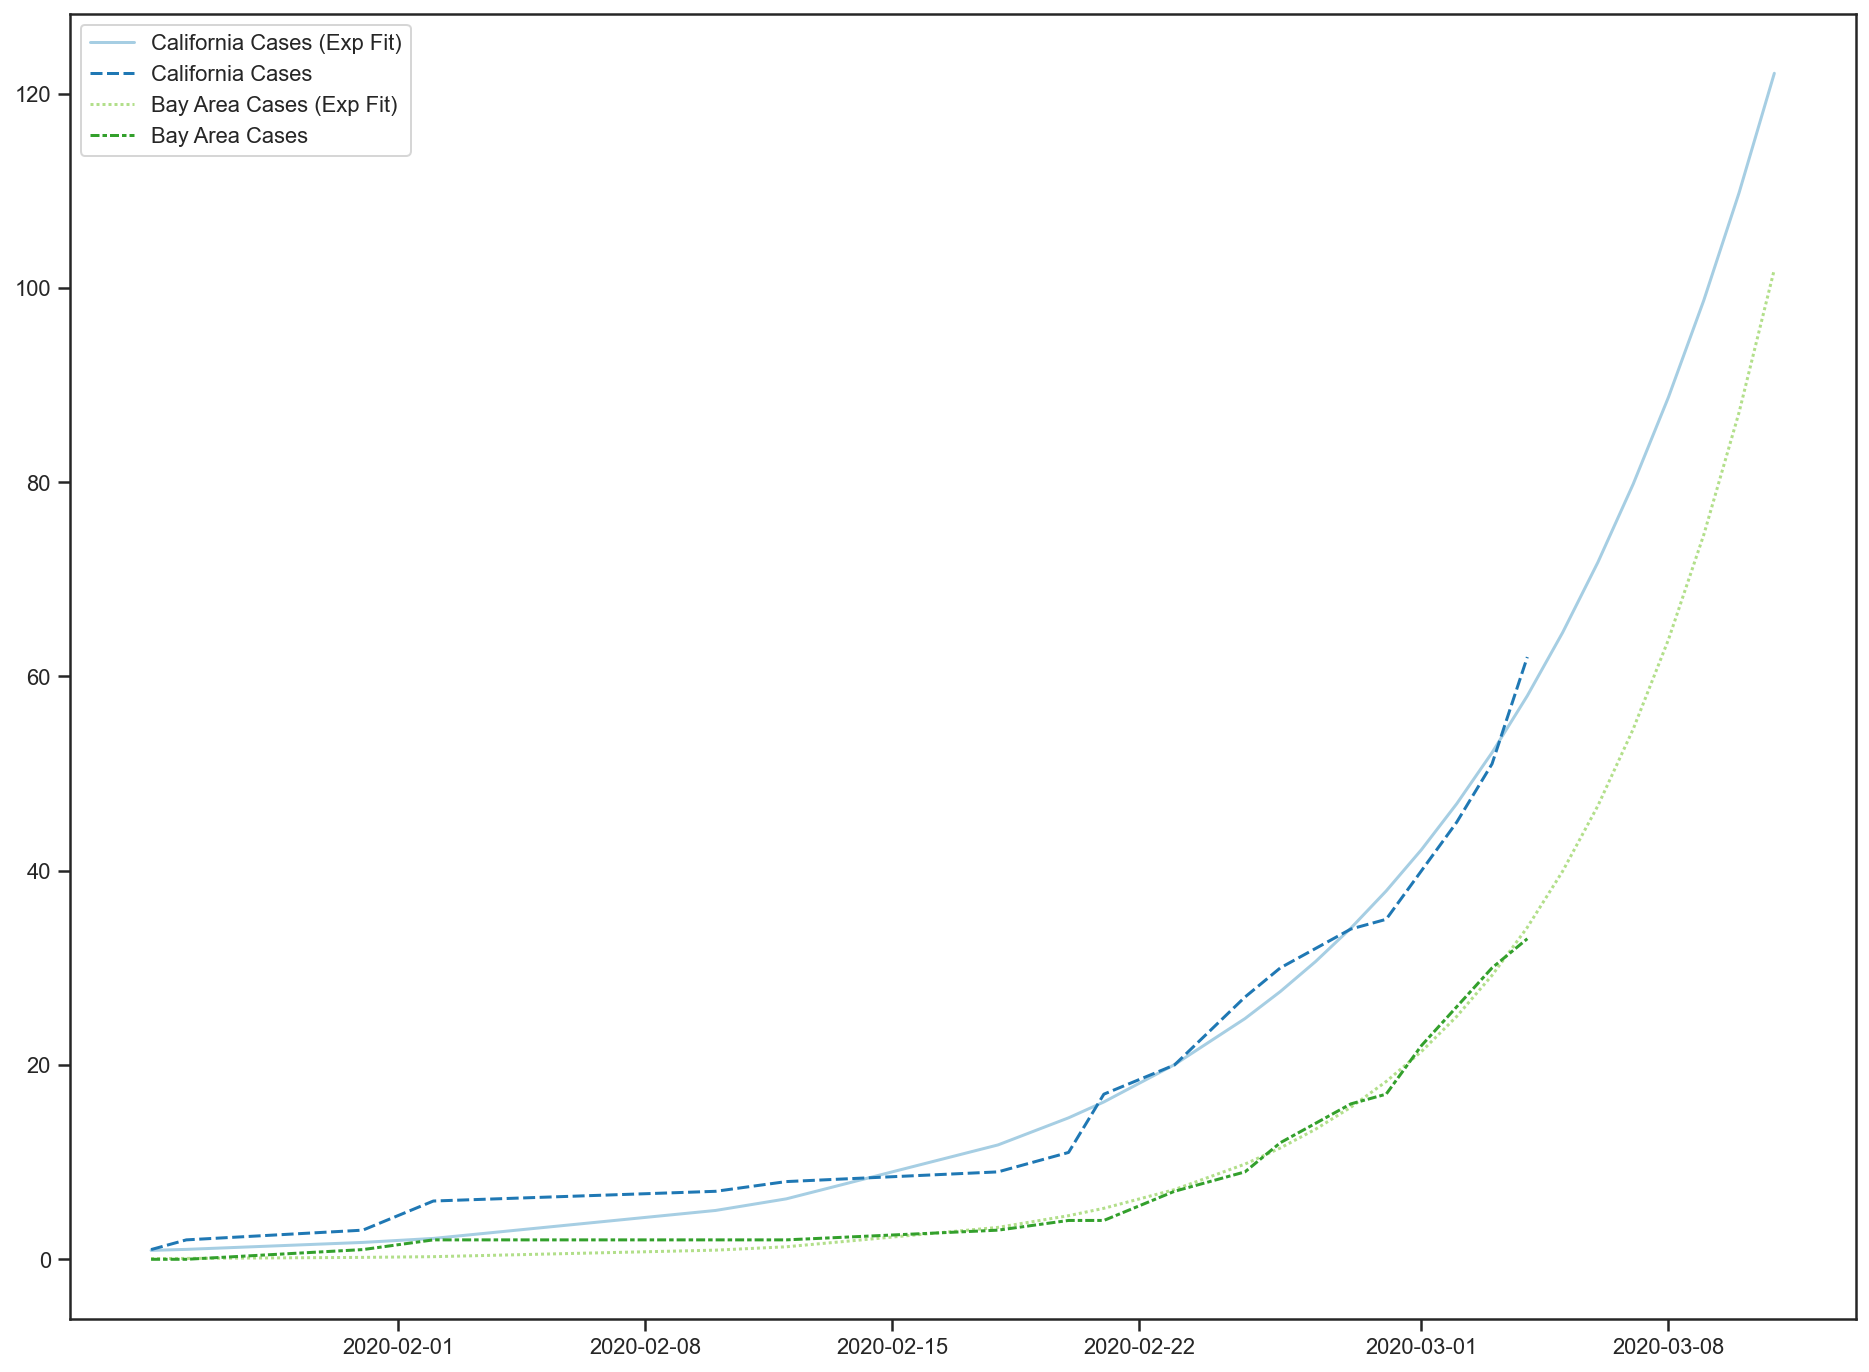

In [155]:
sns.set(style="ticks")
plt.figure(figsize=(16, 12))
sns.set_palette(sns.color_palette("Paired"))

sns.lineplot(data=df_with_fit[['California Cases (Exp Fit)', 'California Cases', 'Bay Area Cases (Exp Fit)', 'Bay Area Cases']])
